In [1]:
# Insert code here.
import pandas as pd
import numpy as np
import random
import re
import time
import datetime
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, neighbors
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, BertConfig
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# from sentence_transformers import SentenceTransformer
# sent_encoder = SentenceTransformer('bert-base-nli-mean-tokens')

In [2]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:1")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
torch.cuda.empty_cache()

There are 4 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


In [3]:
models = ['bert-base-multilingual-cased', 'xlm-roberta-base', 'sagorsarker/bangla-bert-base', 'ai4bharat/indic-bert']
model_num = 3
tokenizer = AutoTokenizer.from_pretrained(models[model_num])


In [4]:
train = pd.read_csv('data/train.tsv', sep='\t')
test = pd.read_csv('data/valid.tsv', sep='\t')

In [5]:
train.sample(20)

,Unique ID,Post,Labels Set
2101,2177,रिया के समर्थन में आईं तापसी- 'सफल व्यक्ति के ...,non-hostile
1555,1623,@aajtak नाम तो पता है लेकिन इस देशद्रोही का ना...,"hate,offensive"
4434,4550,मुख्‍यमंत्री योगी आदित्‍यनाथ के नेतृत्‍व में उ...,non-hostile
3413,3529,"भारत के पूर्व राष्ट्रपति, भारत रत्न श्री प्रणव...",non-hostile
1733,1801,@khanumarfa हो मोहतरमा लोकतंत्र नाम की कौन सी ...,"hate,offensive"
4353,4469,@ajaishukla ब्लैक टॉप और गुरुंग हिल के क्षेत्र...,offensive
1253,1321,फेसबुक पर फरवरी 2019(18 माह) से बीजेपी &amp; ...,non-hostile
5061,5263,पहचान_कौन | #बेशर्मी और #बेईमानी की इन्तिहा तो...,fake
1679,1747,"62 में से 40 रेप के आरोपी, उनके समर्थन से अरवि...",fake
3189,3305,"सावधान रहिए, सतर्क रहिए, संक्रमण से बचे रहिए, ...",non-hostile


In [6]:
labels = list(train['Labels Set'].unique())
labels

['hate,offensive',
 'non-hostile',
 'defamation,offensive',
 'fake',
 'hate',
 'offensive',
 'fake,hate',
 'defamation',
 'defamation,hate',
 'defamation,hate,offensive',
 'defamation,fake,offensive',
 'fake,offensive',
 'defamation,fake',
 'defamation,fake,hate',
 'defamation,fake,hate,offensive',
 'fake,hate,offensive']

In [7]:
def label_encode(val):
    return labels.index(val)

In [8]:
train['Labels Set'] = train['Labels Set'].apply(label_encode)

In [9]:
train = train.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
STOPWORDS = []

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
#     text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
train.Post = train.Post.apply(clean_text)
train.Post = train.Post.str.replace('\d+', '')

In [10]:
test['Labels Set'] = test['Labels Set'].apply(label_encode)
test = test.reset_index(drop=True)
test.Post = test.Post.apply(clean_text)
test.Post = test.Post.str.replace('\d+', '')

In [11]:
# split the dataset into training and validation datasets 
from sklearn.model_selection import train_test_split
# train_x, valid_x, train_y, valid_y = model_selection.train_test_split(train['tweet'], train['label'])
train_x, valid_x, train_y, valid_y = train_test_split(train.Post, train['Labels Set'], test_size=0.2)

In [12]:
def count_words(text):
    try:
        return len(text.split())
    except:
        print(text)
        return None

In [15]:
total = 0
maxw = 0
large_count = 0
for i in train_x:
    temp = count_words(i)
    total += temp
    maxw = temp if temp > maxw else maxw
    large_count += 1 if temp > 120 else 0
total/len(train_x), maxw, large_count, len(train_x)

(31.374123501470255, 2797, 20, 4421)

In [14]:
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 10
posts = train_x.values
categories = train_y.values
best_model_path = '/scratch/best_model_hi.pt'

In [15]:
posts_test = valid_x.values
categories_test = valid_y.values

In [16]:
def train_tokenizer(posts, categories):
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in posts:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            truncation=True,
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(categories)
    return input_ids, attention_masks, labels

In [17]:
def build_dataset(input_ids, attention_masks, labels):
    dataset = TensorDataset(input_ids, attention_masks, labels)
    train_size = int(0.875 * len(dataset))
    val_size = len(dataset) - train_size
    # Divide the dataset by randomly selecting samples.
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    print('{:>5,} training samples'.format(train_size))
    print('{:>5,} validation samples'.format(val_size))
    batch_size = BATCH_SIZE
    train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
    validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )
    return train_dataloader, validation_dataloader

In [18]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
# model = AutoModelForSequenceClassification.from_pretrained(
#     models[model_num], # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = 2, # The number of output labels--2 for binary classification.
#                     # You can increase this for multi-class tasks.
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
# )
def build_model(name):
    model = AutoModelForSequenceClassification.from_pretrained(
        models[model_num], # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = len(labels), # The number of output labels--2 for binary classification.
                        # You can increase this for multi-class tasks.
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        return_dict=True
    )

# Tell pytorch to run this model on the GPU.
    model.to(device)
    params = list(model.named_parameters())
    print('The BERT model has {:} different named parameters.\n'.format(len(params)))

    print('==== Embedding Layer ====\n')

    for p in params[0:5]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

    print('\n==== First Transformer ====\n')

    for p in params[5:21]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

    print('\n==== Output Layer ====\n')

    for p in params[-4:]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

    return model

In [19]:
def build_optimizer(model, train_dataloader):
    optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
    total_steps = len(train_dataloader) * EPOCHS

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
    return optimizer, scheduler

In [20]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [21]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



In [22]:
def train(model, optimizer, scheduler, train_dataloader, validation_dataloader):
    seed_val = 42
    torch.cuda.empty_cache()
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    # For each epoch...
    prev_loss = 0
    prev_acc = 0
    first_epoch = 1
    for epoch_i in range(0, EPOCHS):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            outputs = model(b_input_ids, 
                                 attention_mask=b_input_mask, 
                                 labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                outputs = model(b_input_ids, 
                                       attention_mask=b_input_mask,
                                       labels=b_labels)
                loss = outputs.loss
                logits = outputs.logits


            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)


        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))
        if not first_epoch:
            if prev_loss < avg_val_loss and prev_acc > avg_val_accuracy:
                print("Backtracking")
                model = torch.load(best_model_path)
                for g in optimizer.param_groups:
                    g['lr'] /= 2
            else:
                print("Going on track")
                prev_loss = avg_val_loss
                prev_acc = avg_val_accuracy
                torch.save(model, best_model_path)
        else:
            print("Going on track")
            first_epoch = 0
            prev_loss = avg_val_loss
            prev_acc = avg_val_accuracy
            torch.save(model, best_model_path)

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
#         if epoch_i >= 0:
#             inp = input()
#             if inp.startswith('y'):
#                 break

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    model = torch.load(best_model_path)
    return model, training_stats

In [23]:
def test_model(posts, categories, model):
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in posts:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            truncation=True,
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(categories)
    # Set the batch size.  
    batch_size = 32
    # Create the DataLoader.
    prediction_data = TensorDataset(input_ids, attention_masks, labels)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
    print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions , true_labels = [], []

    # Predict 
    for batch in prediction_dataloader:
      # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, 
                          attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)
    print('    DONE.')
    flat_predictions = np.concatenate(predictions, axis=0)

    # For each sample, pick the label (0 or 1) with the higher score.
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

    # Combine the correct labels for each batch into a single list.
    flat_true_labels = np.concatenate(true_labels, axis=0)
    print(classification_report(flat_true_labels, flat_predictions))

In [24]:
def classifier(name):
    posts = train_x.values
    categories = train_y.values
    input_ids, attention_masks, labels = train_tokenizer(posts, categories)
    train_dataloader, validation_dataloader = build_dataset(input_ids, attention_masks, labels)
    model = build_model(name)
    optimizer, scheduler = build_optimizer(model, train_dataloader)
    model, training_stats = train(model, optimizer, scheduler, train_dataloader, validation_dataloader)
    posts = valid_x.values
    categories = valid_y.values
    test_model(posts, categories, model)
    return training_stats, model

In [25]:
training_stats, model = classifier(models[model_num])

/home/tathagata.raha/miniconda3/envs/fastai/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1764: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


3,868 training samples
  553 validation samples


Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias', 'sop_classifier.classifier.weight', 'sop_classifier.classifier.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indi

The BERT model has 27 different named parameters.

==== Embedding Layer ====

albert.embeddings.word_embeddings.weight                (200000, 128)
albert.embeddings.position_embeddings.weight              (512, 128)
albert.embeddings.token_type_embeddings.weight              (2, 128)
albert.embeddings.LayerNorm.weight                            (128,)
albert.embeddings.LayerNorm.bias                              (128,)

==== First Transformer ====

albert.encoder.embedding_hidden_mapping_in.weight         (768, 128)
albert.encoder.embedding_hidden_mapping_in.bias               (768,)
albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight       (768,)
albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias       (768,)
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight   (768, 768)
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias       (768,)
albert.encoder.albert_layer_groups.0.albert_

/home/tathagata.raha/miniconda3/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:

import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.""
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.20,0.91,0.70,0:01:23,0:00:04
2,0.88,0.95,0.71,0:01:26,0:00:05
3,0.81,0.85,0.72,0:01:24,0:00:04
4,0.72,0.90,0.70,0:01:25,0:00:05
5,0.69,0.85,0.72,0:01:24,0:00:04
6,0.69,0.85,0.72,0:01:24,0:00:04
7,0.69,0.85,0.72,0:01:24,0:00:05
8,0.69,0.85,0.72,0:01:25,0:00:04
9,0.69,0.85,0.72,0:01:24,0:00:04


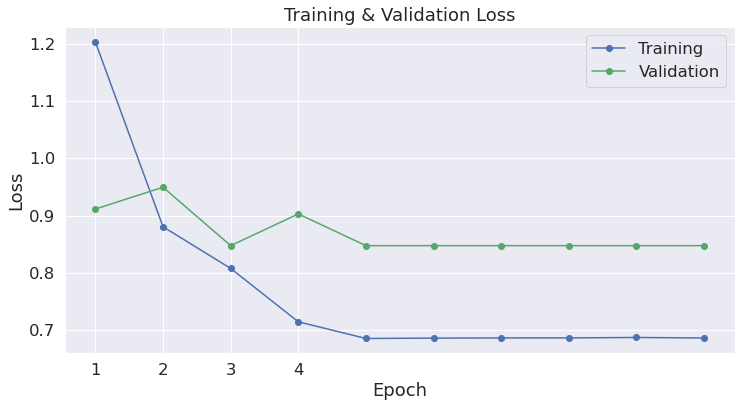

In [27]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [28]:
posts = valid_x.values
categories = valid_y.values

In [29]:
input_ids = []
attention_masks = []

# For every sentence...
for sent in posts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        truncation=True,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(categories)

# Set the batch size.  
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


/home/tathagata.raha/miniconda3/envs/fastai/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1764: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [30]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')


Predicting labels for 1,106 test sentences...
    DONE.


In [31]:
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [32]:
from sklearn.metrics import classification_report
